William Albeiro Amaya Patiño

Realice el proceso de instalación de librerías requeridas para el desarrollo del modelo

In [5]:
import numpy as np
import pandas as pd
import random
import json
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')  # Tokenizer
nltk.download('stopwords')  # Stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eusou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eusou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## NLP - Procesamiento Natural del Lenguage

En este caso vamos a usar un conjunto de datos datos Diplomacy 

El conjunto de datos está disponible en :
(https://sites.google.com/view/qanta/projects/diplomacy?pli=1)


El archivo se encuentra en un formato específico con la extensión .json, por lo que vamos a necesitar algunas librerías adicionales para lectura de este formato.

### Lectura del archivo en formato json

In [6]:
# Función para leer archivos jsonl y convertirlos en un DataFrame de pandas
def read_jsonl(filepath):
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

In [7]:
# Cargar los datos de entrenamiento, validación y prueba desde los archivos .jsonl
train_path = 'train.jsonl'
validation_path = 'validation.jsonl'
test_path = 'test.jsonl'

In [8]:
train_df = read_jsonl(train_path)
validation_df = read_jsonl(validation_path)
test_df = read_jsonl(test_path)

#### Exploración general del conjunto de datos

El archivo cuenta con 13 columnas de información, en particular las de mas interés en este caso son messages que contiene los mensajes realizadas por los jugadores y sender_labels, la cual indica si el mensaje es confiable o mentiroso.

In [9]:
train_df.shape

(189, 13)

In [10]:
train_df.head(2)

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1



El objetivo es analizar cómo se comportan los jugadores que intercambian mensajes en el juego Diplomacy y cuál es la relación entre esos mensajes y la veracidad de los mismos.

Para lograr ese objetivo, lo primero que vamos a realizar es definir el valor para el cual se considera un mensaje como verdadero o falso. En este caso, las etiquetas en la variable sender_labels nos indican si un mensaje es verdadero o falso.

In [11]:
# Función que verifica si hay un False en la lista de etiquetas
def contains_false(labels):
    return 1 if False in labels else 0

In [12]:
# Aplicar la función a la columna sender_labels para crear la columna 'mentira'
train_df['mentira'] = train_df['sender_labels'].apply(contains_false)
validation_df['mentira'] = validation_df['sender_labels'].apply(contains_false)
test_df['mentira'] = test_df['sender_labels'].apply(contains_false)

In [13]:
train_df.head(2)

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id,mentira
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1,1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1,1


In [14]:
# Convertir mensajes a cadenas de texto si son listas
train_df['messages'] = train_df['messages'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
validation_df['messages'] = validation_df['messages'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
test_df['messages'] = test_df['messages'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

In [15]:
train_df.head(2)

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id,mentira
0,Germany!\n\nJust the person I want to speak wi...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1,1
1,Hello there! What's your general plan for this...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1,1


# Análisis Exploratorio de Datos (EDA)

Para analizar mejor el conjunto de datos, se calculará la frecuencia de ocurrencia de mensajes etiquetados como verdaderos o falsos en la variable sender_labels, es decir, cuáles son las proporciones de mensajes en cada categoría.

### 1. Distribución de las clases

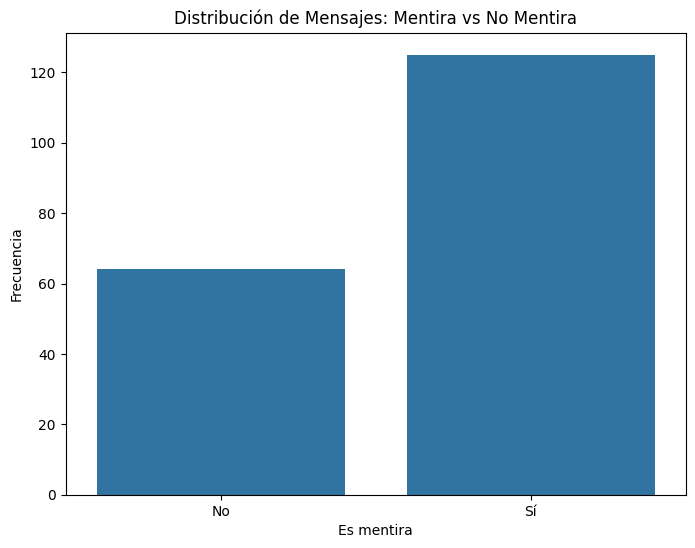

In [16]:
plt.figure(figsize=(8, 6)) # tamaño de la figura '8' representa el ancho de la figura y  '6' el alto de la figura.
sns.countplot(x='mentira', data=train_df) #de la libreria seaborn se crea un grafico de barras con el recuento de x='mentira' del dataframe train_df 
plt.title('Distribución de Mensajes: Mentira vs No Mentira') #Titulo principal
plt.xlabel('Es mentira') #titulo del eje x
plt.ylabel('Frecuencia') #titulo del eje y
plt.xticks(ticks=[0, 1], labels=['No', 'Sí']) # Especifica las posiones de las etiquetas en el eje x, '0' se etiqueta como 'No' y '1' se etiqueta como 'Si'
plt.show() #mostrar el grafico

### 2. Estadísticas de la longitud de los mensajes

In [17]:
train_df['messagelen'] = train_df['messages'].apply(len) # Calcular la longitud de cada mensaje en el conjunto de entrenamiento
validation_df['messagelen'] = validation_df['messages'].apply(len) # Calcular la longitud de cada mensaje en el conjunto de validación
test_df['messagelen'] = test_df['messages'].apply(len) #Calcular la longitud de cada mensaje en el conjunto de prueba

print("Estadísticas de la longitud de los mensajes en el conjunto de entrenamiento:")
print(train_df['messagelen'].describe()) #Muestra las estadísticas descriptivas de la longitud de los mensajes en train_df
print("\nEstadísticas de la longitud de los mensajes en el conjunto de validación:")
print(validation_df['messagelen'].describe()) #Muestra las estadísticas descriptivas de la longitud de los mensajes en validation_df
print("\nEstadísticas de la longitud de los mensajes en el conjunto de prueba:")
print(test_df['messagelen'].describe()) #Muestra las estadísticas descriptivas de la longitud de los mensajes en test_df

Estadísticas de la longitud de los mensajes en el conjunto de entrenamiento:
count       189.000000
mean       7538.412698
std       12118.347932
min           0.000000
25%         884.000000
50%        3055.000000
75%        8285.000000
max      100047.000000
Name: messagelen, dtype: float64

Estadísticas de la longitud de los mensajes en el conjunto de validación:
count       21.000000
mean      6407.000000
std       7781.356829
min          0.000000
25%       1200.000000
50%       2918.000000
75%      10829.000000
max      25391.000000
Name: messagelen, dtype: float64

Estadísticas de la longitud de los mensajes en el conjunto de prueba:
count       42.000000
mean      6533.309524
std       9056.216015
min        187.000000
25%        888.500000
50%       2140.000000
75%       9073.500000
max      38979.000000
Name: messagelen, dtype: float64


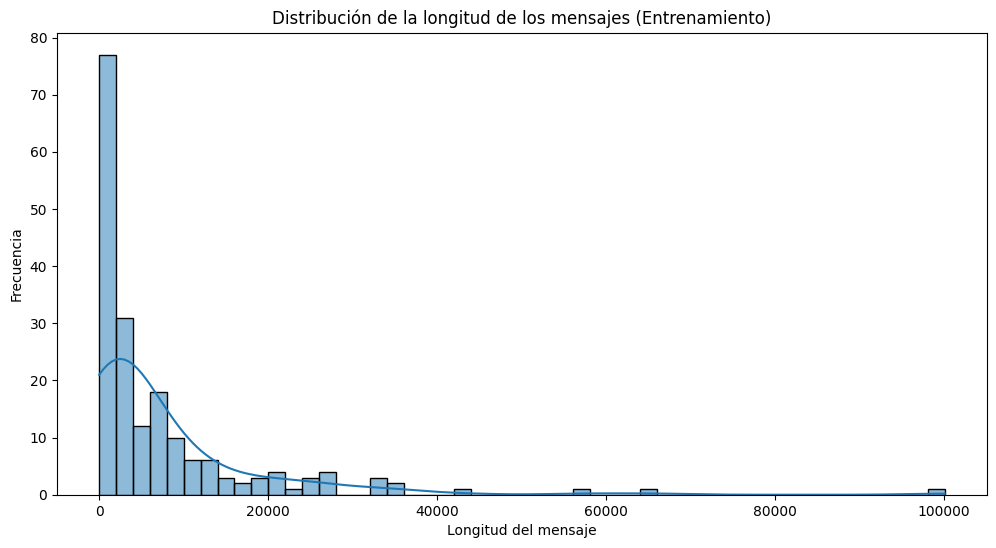

In [18]:
# Histograma de la longitud de los mensajes
plt.figure(figsize=(12, 6)) # tamaño de la figura '12' representa el ancho de la figura y  '6' el alto de la figura.
# sns.histplot crea un histograma, bins=50 divide los datos en 50 intervalos (kde=True) añade una curva suave que representa la densidad de probabilidad de la longitud de los mensajes
sns.histplot(train_df['messagelen'], bins=50, kde=True) 
plt.title('Distribución de la longitud de los mensajes (Entrenamiento)')
plt.xlabel('Longitud del mensaje')

plt.ylabel('Frecuencia')
plt.show() #Muestra el histograma

### 3. Palabras más comunes

In [19]:
#Las stopwords son palabras comunes que no aportan mucho significado en el análisis de texto, como "the", "is", "in", etc.
stop_words = set(stopwords.words('english')) # usando NLTK:set convierte la lista en un conjunto para mejorar la eficiencia de búsqueda durante el filtrado de palabras.

def preprocess_text(text): #Esta funcion toma un string de texto 
    #Divide el texto en palabras individuales (tokens): This is a test." se convierte en ['This', 'is', 'a', 'test', '.']
    tokens = word_tokenize(text)
    #Convierte cada palabra a minúsculas y filtra aquellas que contienen solo caracteres alfabéticos, eliminando así puntuación y otros símbolos.
    tokens = [word.lower() for word in tokens if word.isalpha()]
    #Filtra las palabras que están en el conjunto de stopwords, eliminando palabras comunes que no añaden valor significativo al análisis.
    tokens = [word for word in tokens if word not in stop_words]
    #La función devuelve la lista de tokens preprocesados, listos para análisis o modelado.
    return tokens

#Aplica la función a cada elemento de la columna, crando una nueva columna 'tokenized_messages'
train_df['tokenized_messages'] = train_df['messages'].apply(preprocess_text)

In [20]:
# Contar las palabras más comunes
#es una lista que contiene todas las palabras (tokens) de todos los mensajes preprocesados en el conjunto de datos de entrenamiento.
all_words = [word for tokens in train_df['tokenized_messages'] for word in tokens]
#Cuenta la frecuencia de palabras
word_freq = Counter(all_words)
# se obtiene una lista de tuplas, donde cada tupla contiene una palabra y su frecuencia. Por ejemplo, [('word1', 100), ('word2', 95), ...]
common_words = word_freq.most_common(20)

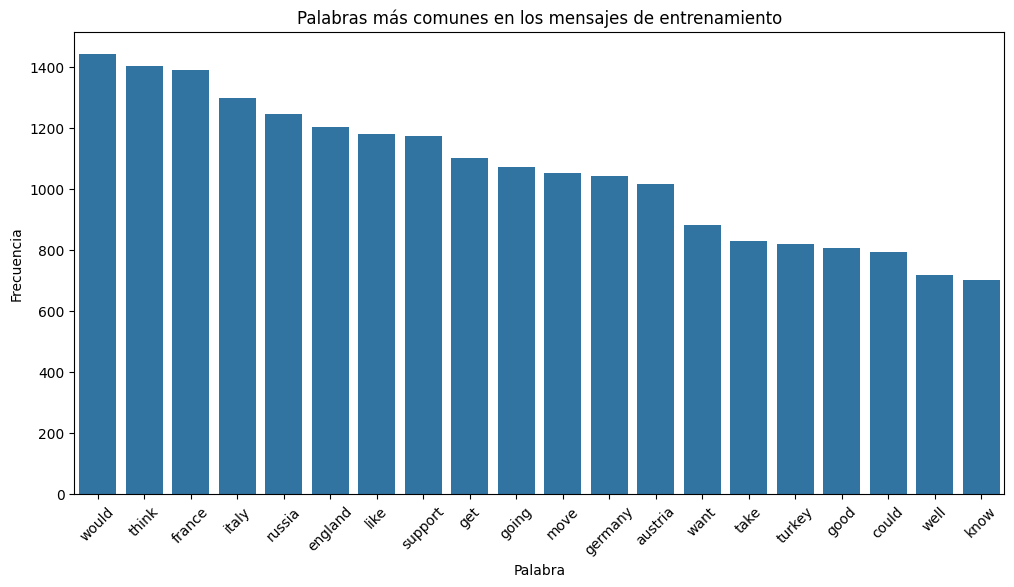

In [21]:
# Mostrar las palabras más comunes
plt.figure(figsize=(12, 6)) #figura con un tamaño de 12 pulgadas de ancho y 6 pulgadas de alto
#Utiliza la función barplot de Seaborn para crear el gráfico de barras.
#x=[word[0] for word in common_words] : Las palabras se utilizan como etiquetas en el eje x.
#y=[word[1] for word in common_words] : extrae las frecuencias correspondientes a cada palabra en common_words para ser usadas como valores en el eje y del gráfico.
sns.barplot(x=[word[0] for word in common_words], y=[word[1] for word in common_words])
plt.title('Palabras más comunes en los mensajes de entrenamiento')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45) #ira las etiquetas del eje x 45 grados para que sean más legibles
plt.show()

### 4. Nube de palabras

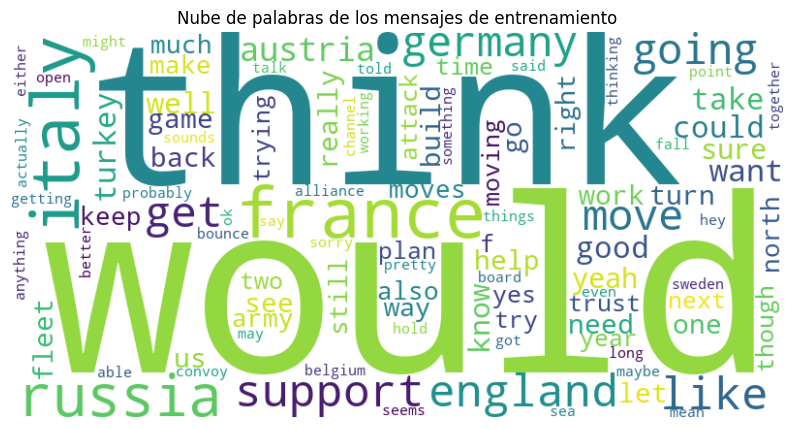

In [22]:
#wordcloud:  Esta es una función de la biblioteca wordcloud que genera una nube de palabras.
#width=800, height=400: Establece el tamaño de la imagen de la nube de palabras, en este caso, 800 píxeles de ancho y 400 píxeles de alto
#max_words=100: Limita el número máximo de palabras que se mostrarán en la nube. Las palabras más frecuentes serán las que se incluyan, hasta un máximo de 100.
#background_color='white': Define el color de fondo de la nube de palabras. Aquí se utiliza el color blanco.
#generate_from_frequencies(word_freq): Genera la nube de palabras a partir de un diccionario de frecuencias de palabras (word_freq). 
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 8))
#Muestra la imagen generada de la nube de palabras.
plt.imshow(wordcloud, interpolation='bilinear') #interpolation='bilinear': Mejora la visualización de la imagen suavizando los bordes de las palabras,
plt.title('Nube de palabras de los mensajes de entrenamiento')
plt.axis('off') #Apaga los ejes de la figura
plt.show()

# Inicializar el tokenizer de BERT

Carga un tokenizador Bert es capaz de dividir textos en tokens sin considerar si las palabras están en mayúsculas o minúsculas.

Explicación_

BertTokenizer: Es una clase de la biblioteca transformers de Hugging Face que se utiliza para convertir texto en una secuencia de tokens.

from_pretrained:Este método carga un modelo de tokenización preentrenado.

bert-base: Indica que se está utilizando la versión base de BERT, que tiene 12 capas, 768 dimensiones ocultas y 12 cabezas de atención. Es un modelo más ligero comparado con bert-large

uncased: Indica que el modelo no distingue entre mayúsculas y minúsculas, es decir, todas las letras se convierten a minúsculas durante la tokenización

In [23]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [24]:
#Ejemplo
tokenizer.tokenize("My dog lover strawberries.")


['my', 'dog', 'lover', 'straw', '##berries', '.']

In [25]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("My dog lover strawberries."))


[2026, 3899, 7089, 13137, 20968, 1012]

# Función para tokenizar los datos


La función **tokenize_data(df)** se utiliza para tokenizar los mensajes de texto contenidos en un DataFrame df. Esta función toma cada mensaje de la columna 'messages' 

y lo convierte en una secuencia de tokens que puede ser utilizada como entrada para modelos de aprendizaje profundo como BERT.

Explicación de los componentes: 

**df['messages'].tolist():** Convierte la columna de mensajes a una lista de textos.

**tokenizer(...):** Aplica el tokenizador BERT a los textos para:

**padding=True:** Añadir padding para igualar la longitud de las secuencias.

**truncation=True:** Truncar los mensajes que superen la longitud máxima.

**max_length=128:** Establecer la longitud máxima de los tokens a 128.

**return_tensors='pt':** Devuelve los resultados como tensores de PyTorch


In [26]:
def tokenize_data(df):
    return tokenizer(df['messages'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')

# Tokenizar los datos de entrenamiento, validación y prueba

Convierte los textos en secuencias de tokens que BERT puede procesar, con padding y truncamiento para asegurar una longitud uniforme.

In [27]:
train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(validation_df)
test_encodings = tokenize_data(test_df)

In [28]:
train_encodings


{'input_ids': tensor([[  101,  2762,   999,  ...,  3304,  1012,   102],
        [  101,  7592,  2045,  ...,  1045,  2323,   102],
        [  101, 20934,  5063,  ...,  2078,  3467,   102],
        ...,
        [  101,  4931,  7592,  ...,     0,     0,     0],
        [  101,  7592,  2605,  ...,  2215,  3304,   102],
        [  101,   102,     0,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 0,  ..., 0, 0, 0]])}

# Clase personalizada para manejar el dataset tokenizado


La clase DiplomacyDataset es una subclase de torch.utils.data.Dataset y se utiliza para manejar los datos tokenizados y sus etiquetas en PyTorch.

Propósito:

Facilitar el acceso estructurado a los datos y etiquetas.

Compatible con DataLoader de PyTorch para cargar datos en lotes.

Estandariza la manipulación de datos para el entrenamiento y evaluación de modelos de aprendizaje profundo.

In [29]:
class DiplomacyDataset(Dataset):
    def __init__(self, encodings, labels): # Inicializa con secuencias de tokens (encodings) y etiquetas (labels).
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx): # Devuelve el diccionario item con los datos de entrada y la etiqueta en el índice idx.
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self): #Devuelve el número de ejemplos en el conjunto de datos.
        return len(self.labels)

# Crear los datasets de entrenamiento, validación y prueba

Se crea las instancias de la clase DiplomacyDataset para los conjuntos de datos de entrenamiento, validación y prueba,

usando los datos tokenizados y las etiquetas correspondientes

In [30]:
train_dataset = DiplomacyDataset(train_encodings, train_df['mentira'].tolist())
val_dataset = DiplomacyDataset(val_encodings, validation_df['mentira'].tolist())
test_dataset = DiplomacyDataset(test_encodings, test_df['mentira'].tolist())

# Inicializar el modelo BERT para clasificación de secuencias

Se carga un modelo BERT preentrenado para la clasificación de texto.

**BertForSequenceClassification:** Modelo BERT adaptado para tareas de clasificación.

**from_pretrained('bert-base-uncased'):** Usa el modelo preentrenado "bert-base-uncased", que no distingue entre mayúsculas y minúsculas.

**num_labels=2:** Configura el modelo para una tarea de clasificación binaria.

In [31]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Definir los argumentos del entrenamiento

Los siguientes argumentos se configuran cómo se entrena el modelo BERT, incluyendo la gestión de tasas de aprendizaje, el número de épocas, el tamaño de los lotes,

 y el almacenamiento de los modelos. Son esenciales para controlar el proceso de entrenamiento y asegurar que el modelo converja de manera efectiva y eficiente

In [46]:
training_args = TrainingArguments(
    output_dir='./results', #Directorio donde se guardarán los resultados del entrenamiento, como los modelos guardados y los logs.
    num_train_epochs=10,              # Aumentar el número de épocas a 10,es decir, cuántas veces el modelo verá todo el conjunto de entrenamiento
    per_device_train_batch_size=32,   # Aumentar el tamaño del lote de entrenamiento a 32 (optimizar el uso de recursos computacionales)
    per_device_eval_batch_size=32,    # Aumentar el tamaño del lote de evaluación a 32
    warmup_steps=1000,                # Aumentar los pasos de calentamiento a 1000
    weight_decay=0.1,                 # Aumentar el decaimiento del peso a 0.1
    logging_dir='./logs',             # Directorio para guardar los logs
    logging_steps=10,                 # Intervalo de pasos para logging
    evaluation_strategy="epoch",      # Estrategia para la evaluación. Especifica que el modelo se evaluará al final de cada época.
    save_strategy="epoch",            # Estrategia para guardar el modelo. Se guarda el modelo al final de cada época.
    learning_rate=3e-5,               # un hiperparámetro crítico que controla qué tan rápido se actualizan los pesos del modelo durante el entrenamiento
    save_total_limit=3,               # Solo se guardan los últimos 3 checkpoints para ahorrar espacio.
    load_best_model_at_end=True,      # Indica que el mejor modelo (según la métrica especificada) debe cargarse al final del entrenamiento.
    metric_for_best_model='eval_loss' # Aquí se usa la pérdida de evaluación (eval_loss) para seleccionar el mejor modelo.
)

# Definir una función de evaluación personalizada

**compute_metrics(pred)** proporciona una forma estandarizada de evaluar el rendimiento de un modelo de clasificación binaria.

In [47]:
def compute_metrics(pred):
    labels = pred.label_ids
    # Calcula las predicciones del modelo. 
    #pred.predictions contiene las puntuaciones de las clases para cada instancia
    #argmax(-1) selecciona el índice de la clase con la puntuación más alta para cada clase predicha
    preds = pred.predictions.argmax(-1)
    # Calcula varias métricas de evaluación
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary') 
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Inicializar el Trainer de Hugging Face


La instancia **trainer** se crea utilizando la clase Trainer de la biblioteca transformers de Hugging Face. Esta clase facilita el proceso de entrenamiento 

y evaluación de modelos de aprendizaje profundo, como BERT, para tareas de procesamiento de lenguaje natural (NLP)

In [48]:
trainer = Trainer(
    model=model,#Especifica el modelo de aprendizaje profundo que se va a entrenar y evaluar. En este caso, es una instancia de BertForSequenceClassification
    args=training_args,#training_args: Incluye los parámetros de entrenamiento definidos anteriormente utilizando TrainingArguments.
    train_dataset=train_dataset,# es una instancia de DiplomacyDataset que contiene las secuencias de tokens de los datos de entrenamiento y sus etiquetas correspondientes
    eval_dataset=val_dataset,#es una instancia de DiplomacyDataset, pero contiene los datos y etiquetas para la evaluación del modelo durante el entrenamiento.
    compute_metrics=compute_metrics #calcula la precisión, recall, F1-score y exactitud (accuracy) a partir de las predicciones y las etiquetas verdaderas.
)

# Entrenar el modelo

El modelo ha alcanzado una buena capacidad para identificar correctamente los ejemplos positivos (recall = 1.0) y tiene una precisión aceptable (0.7). La exactitud de 71.4% sugiere que el modelo es razonablemente eficaz, pero hay margen de mejora

eval_loss (Pérdida de Evaluación): de 0.607, indicando una ligera mejora con el progreso del entrenamiento.

eval_accuracy (Exactitud de Evaluación): 71.4%, lo que significa que el modelo clasifica correctamente el 71.4% de los ejemplos de validación.

eval_f1 (F1-Score): Un valor de 0.823 sugiere un buen equilibrio entre estos dos componentes, indicando que el modelo tiene un buen rendimiento tanto en identificar correctamente los ejemplos positivos como en no etiquetar incorrectamente los negativos.

eval_precision (Precisión de Evaluación):Un valor de 0.7 indica que el 70% de las predicciones positivas del modelo son correctas.

eval_recall (Recall de Evaluación): Un recall de 1.0 indica que el modelo ha identificado correctamente todos los ejemplos positivos en el conjunto de validación, lo cual es un muy buen resultado.


In [49]:
trainer.train()

 10%|█         | 6/60 [01:35<13:15, 14.73s/it]

{'eval_loss': 0.6067808866500854, 'eval_accuracy': 0.7142857142857143, 'eval_f1': 0.8235294117647058, 'eval_precision': 0.7, 'eval_recall': 1.0, 'eval_runtime': 3.4683, 'eval_samples_per_second': 6.055, 'eval_steps_per_second': 0.288, 'epoch': 1.0}


 17%|█▋        | 10/60 [02:37<12:53, 15.46s/it]

{'loss': 0.589, 'grad_norm': 2.251030445098877, 'learning_rate': 3.0000000000000004e-07, 'epoch': 1.67}


 20%|██        | 12/60 [03:08<11:44, 14.68s/it]

{'eval_loss': 0.6067898273468018, 'eval_accuracy': 0.7142857142857143, 'eval_f1': 0.8235294117647058, 'eval_precision': 0.7, 'eval_recall': 1.0, 'eval_runtime': 3.3904, 'eval_samples_per_second': 6.194, 'eval_steps_per_second': 0.295, 'epoch': 2.0}


 30%|███       | 18/60 [04:43<10:38, 15.20s/it]

{'eval_loss': 0.6071040630340576, 'eval_accuracy': 0.7142857142857143, 'eval_f1': 0.8235294117647058, 'eval_precision': 0.7, 'eval_recall': 1.0, 'eval_runtime': 3.9752, 'eval_samples_per_second': 5.283, 'eval_steps_per_second': 0.252, 'epoch': 3.0}


 33%|███▎      | 20/60 [05:17<11:06, 16.66s/it]

{'loss': 0.6012, 'grad_norm': 3.9406986236572266, 'learning_rate': 6.000000000000001e-07, 'epoch': 3.33}


 40%|████      | 24/60 [06:18<08:53, 14.82s/it]

{'eval_loss': 0.6084546446800232, 'eval_accuracy': 0.7142857142857143, 'eval_f1': 0.8235294117647058, 'eval_precision': 0.7, 'eval_recall': 1.0, 'eval_runtime': 3.3761, 'eval_samples_per_second': 6.22, 'eval_steps_per_second': 0.296, 'epoch': 4.0}


 50%|█████     | 30/60 [07:47<07:20, 14.68s/it]

{'loss': 0.573, 'grad_norm': 6.419702529907227, 'learning_rate': 9e-07, 'epoch': 5.0}



 50%|█████     | 30/60 [07:51<07:20, 14.68s/it]

{'eval_loss': 0.6106680631637573, 'eval_accuracy': 0.7142857142857143, 'eval_f1': 0.8235294117647058, 'eval_precision': 0.7, 'eval_recall': 1.0, 'eval_runtime': 3.531, 'eval_samples_per_second': 5.947, 'eval_steps_per_second': 0.283, 'epoch': 5.0}


 60%|██████    | 36/60 [09:23<05:54, 14.78s/it]

{'eval_loss': 0.6113636493682861, 'eval_accuracy': 0.7142857142857143, 'eval_f1': 0.8235294117647058, 'eval_precision': 0.7, 'eval_recall': 1.0, 'eval_runtime': 3.3104, 'eval_samples_per_second': 6.344, 'eval_steps_per_second': 0.302, 'epoch': 6.0}


 67%|██████▋   | 40/60 [10:26<05:13, 15.67s/it]

{'loss': 0.5633, 'grad_norm': 4.217746257781982, 'learning_rate': 1.2000000000000002e-06, 'epoch': 6.67}


 70%|███████   | 42/60 [10:58<04:28, 14.91s/it]

{'eval_loss': 0.6110842823982239, 'eval_accuracy': 0.7142857142857143, 'eval_f1': 0.8235294117647058, 'eval_precision': 0.7, 'eval_recall': 1.0, 'eval_runtime': 3.1798, 'eval_samples_per_second': 6.604, 'eval_steps_per_second': 0.314, 'epoch': 7.0}


 80%|████████  | 48/60 [12:34<03:01, 15.11s/it]

{'eval_loss': 0.6111811399459839, 'eval_accuracy': 0.7142857142857143, 'eval_f1': 0.8235294117647058, 'eval_precision': 0.7, 'eval_recall': 1.0, 'eval_runtime': 3.6307, 'eval_samples_per_second': 5.784, 'eval_steps_per_second': 0.275, 'epoch': 8.0}


 83%|████████▎ | 50/60 [13:05<02:41, 16.14s/it]

{'loss': 0.5699, 'grad_norm': 3.1265084743499756, 'learning_rate': 1.5e-06, 'epoch': 8.33}


 90%|█████████ | 54/60 [14:07<01:28, 14.77s/it]

{'eval_loss': 0.6096296906471252, 'eval_accuracy': 0.7142857142857143, 'eval_f1': 0.8235294117647058, 'eval_precision': 0.7, 'eval_recall': 1.0, 'eval_runtime': 3.2997, 'eval_samples_per_second': 6.364, 'eval_steps_per_second': 0.303, 'epoch': 9.0}


100%|██████████| 60/60 [15:36<00:00, 14.37s/it]

{'loss': 0.5505, 'grad_norm': 5.006253242492676, 'learning_rate': 1.8e-06, 'epoch': 10.0}



100%|██████████| 60/60 [15:41<00:00, 14.37s/it]

{'eval_loss': 0.6071650385856628, 'eval_accuracy': 0.7142857142857143, 'eval_f1': 0.8235294117647058, 'eval_precision': 0.7, 'eval_recall': 1.0, 'eval_runtime': 3.2737, 'eval_samples_per_second': 6.415, 'eval_steps_per_second': 0.305, 'epoch': 10.0}


100%|██████████| 60/60 [15:43<00:00, 15.72s/it]

{'train_runtime': 943.27, 'train_samples_per_second': 2.004, 'train_steps_per_second': 0.064, 'train_loss': 0.574506409962972, 'epoch': 10.0}


TrainOutput(global_step=60, training_loss=0.574506409962972, metrics={'train_runtime': 943.27, 'train_samples_per_second': 2.004, 'train_steps_per_second': 0.064, 'total_flos': 124319973657600.0, 'train_loss': 0.574506409962972, 'epoch': 10.0})

# Evaluar el modelo en el conjunto de validación

eval_loss: 0.6667  la pérdida es moderada, sugiriendo que el modelo no es completamente preciso.

eval_accuracy: 0.7143 (71.43%) Un 71.43% sugiere que el modelo clasifica correctamente aproximadamente siete de cada diez ejemplos.

eval_f1: 0.8235 (82.35%) El F1-score es la media armónica de la precisión y el recall. Un F1-score de 0.8235 indica un buen equilibrio entre precisión y recall, lo que sugiere que el modelo es bueno tanto para identificar correctamente los positivos como para evitar falsos positivos.

eval_precision: 0.7 (70%) Un 70% indica que el modelo es razonablemente bueno para predecir correctamente los ejemplos positivos.

eval_recall: 1.0 (100%) Un valor de 1.0 indica que el modelo ha identificado correctamente todos los ejemplos positivos, lo cual es excelente.



In [50]:
results = trainer.evaluate()
print(results)

100%|██████████| 1/1 [00:00<00:00, 44.44it/s]

{'eval_loss': 0.6067808866500854, 'eval_accuracy': 0.7142857142857143, 'eval_f1': 0.8235294117647058, 'eval_precision': 0.7, 'eval_recall': 1.0, 'eval_runtime': 3.2609, 'eval_samples_per_second': 6.44, 'eval_steps_per_second': 0.307, 'epoch': 10.0}


# Evaluar el modelo en el conjunto de prueba

test_loss: 0.6437indica que el modelo tiene una cantidad moderada de error.

test_accuracy: 0.6667 (66.67%) indica que el modelo predice correctamente aproximadamente dos de cada tres ejemplos.

test_f1: 0.8 (80%) el modelo tiene un buen equilibrio entre identificar correctamente los positivos y evitar falsos positivos.

test_precision: 0.6667 (66.67%) indica que el modelo es moderadamente bueno en evitar falsos positivos.

test_recall: 1.0 (100%) indica que el modelo identificó correctamente todos los ejemplos positivos en el conjunto de prueba.

In [51]:
test_results = trainer.predict(test_dataset)
print(test_results)

100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

PredictionOutput(predictions=array([[-0.59998953,  0.35625774],
       [-0.7037065 ,  0.33167434],
       [-0.65982854,  0.1473224 ],
       [-0.7475575 ,  0.10823635],
       [-0.01287001,  0.30497563],
       [-0.53607774,  0.25215623],
       [-0.62837577,  0.3078487 ],
       [-0.8063981 ,  0.2496267 ],
       [-0.6968058 ,  0.3155268 ],
       [-0.41398877,  0.33918846],
       [-0.77868646,  0.3455425 ],
       [-0.57477415,  0.33900458],
       [-0.57335734,  0.15330242],
       [-0.5356287 ,  0.16917206],
       [-0.63309145,  0.2117684 ],
       [-0.5739734 ,  0.33142617],
       [-0.5096542 ,  0.278715  ],
       [-0.61405385,  0.31285405],
       [-0.31170648,  0.3639611 ],
       [-0.48483056,  0.42990625],
       [-0.5330004 ,  0.3650907 ],
       [-0.6748885 ,  0.35691828],
       [-0.6367695 ,  0.34217766],
       [-0.63067687,  0.21415572],
       [-0.6966064 ,  0.31882176],
       [-0.7000201 ,  0.36926   ],
       [-0.7545487 ,  0.35253453],
       [-0.46448857,  0.38